In [1]:
import pandas as pd

In [2]:
PATH = 'data/d.csv'

In [3]:
csv = pd.read_csv(PATH)

In [4]:
csv

,plant.ID,y,alpha
0,1,0,-4.159582
1,2,0,-3.718362
2,3,0,-3.069020
3,4,0,-3.054211
4,5,0,-2.880656
5,6,2,-2.705595
6,7,1,-2.441703
7,8,1,-2.221327
8,9,0,-2.209120
9,10,1,-2.111941


In [5]:
ys = csv['y'].values

In [6]:
import numpy as np

histo_ys = np.zeros(11)
for y in ys:
    histo_ys[y] += 1
print(histo_ys)
print(np.sum(histo_ys))

[  7.  10.  10.   5.  12.  11.  11.   7.  14.   9.   4.]
100.0


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

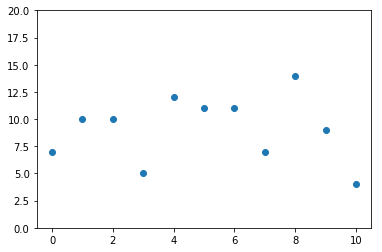

In [8]:
xs = np.arange(11)
plt.scatter(xs, histo_ys)
plt.ylim(0, 20)
plt.show()

In [9]:
import pymc3 as pm

In [10]:
ys

array([ 0,  0,  0,  0,  0,  2,  1,  1,  0,  1,  2,  2,  1,  1,  4,  1,  1,
        1,  1,  2,  4,  2,  2,  6,  2,  3,  0,  3,  6,  5,  2,  4,  1,  5,
        5,  3,  4,  4,  3,  5,  2,  3,  5,  6,  4,  4,  5,  2,  6,  6,  8,
        4,  6,  5,  5,  7,  4,  6,  4,  5,  5,  4,  6,  7,  4,  5,  6, 10,
        9, 10,  8,  7,  8,  6,  8,  8,  8,  9,  9,  8,  9,  7,  8,  7,  7,
        8,  8,  9,  8,  9,  9,  9,  8,  7,  6,  8,  8,  9, 10, 10])

In [11]:
model = pm.Model()
with model:
    q = pm.Uniform('q', lower=0, upper=1)
    y = pm.Binomial('y', n=10, p=q, observed=ys)
    map_estimate = pm.find_MAP(model=model)

logp = -316.78, ||grad|| = 4: 100%|██████████| 5/5 [00:00<00:00, 57.06it/s]


In [12]:
print((float(map_estimate['q'])))

0.4960000053023121


In [13]:
import scipy

In [14]:
rv = scipy.stats.binom(10, map_estimate['q'])
binom_ys = [100 * rv.pmf(k) for k in range(11)]

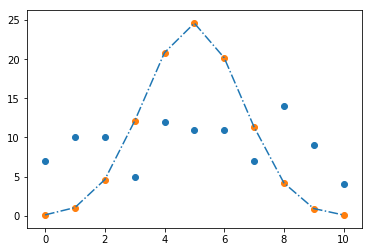

In [15]:
plt.scatter(xs, histo_ys)
plt.plot(xs, binom_ys, ls='-.')
plt.scatter(xs, binom_ys)
plt.show()

In [34]:
model = pm.Model()
with model:
    beta = pm.Normal('beta', mu=0, sd=100)
    sigma = 1 / pm.Gamma('1/sigma', alpha=1.0e-02, beta=1.0e-02)
    alpha = pm.Normal('alpha', mu=0, sd=sigma)
    ymu = pm.math.sigmoid(beta + alpha)
    y = pm.Binomial('y', n=10, p=ymu, observed=ys)
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(1000, step=step, start=start)
    

logp = -327.85, ||grad|| = 0.00018148: 100%|██████████| 12/12 [00:00<00:00, 1360.98it/s]  
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, 1/sigma, beta]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:22<00:00, 263.58draws/s] 
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.916573366274, but should be close to 0.8. Try to increase the number of tuning steps.
There were 508 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.0505505109909, but should be close to 0.8. Try to increase the number of tuning steps.
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.151520298282, but should be close to 0.8. Try to increase the number of tuning steps.
There were 469 divergences after tuning. Increase `target_accept

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c15675470>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c18dc71d0>]], dtype=object)

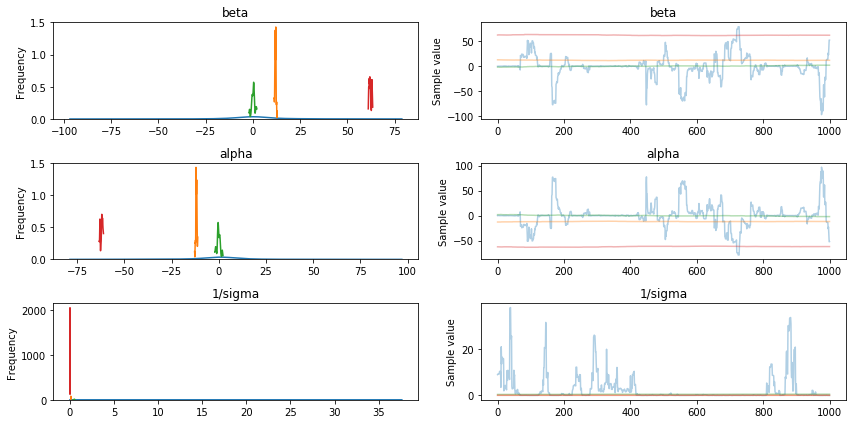

In [35]:
pm.traceplot(trace)

In [36]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta,18.38,28.12,2.69,-8.36,63.40,2.4,2.80
alpha,-18.39,28.12,2.69,-63.39,8.43,2.4,2.80
1/sigma,0.81,3.04,0.19,0.00,3.35,35.5,1.09


In [19]:
beta_samples = trace['beta'][:]
print(type(beta_samples), beta_samples.shape)
alpha_samples = trace['alpha'][:]
print(type(alpha_samples), alpha_samples.shape)

<class 'numpy.ndarray'> (8000,)
<class 'numpy.ndarray'> (8000,)


In [20]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

In [21]:
q_samples = sigmoid(beta_samples + alpha_samples)

In [22]:
rows, = q_samples.shape

In [23]:
y_samples = np.empty((rows, 11))
print(y_samples.shape)
for i in range(rows):
    rv = scipy.stats.binom(10, q_samples[i])
    y_samples[i] = [100 * rv.pmf(k) for k in range(11)]

(8000, 11)


In [24]:
y_samples.shape

(8000, 11)

In [25]:
y_mean = y_samples.mean(axis=0)
y_mean.shape

(11,)

In [26]:
y_std = y_samples.std(axis=0)
y_std.shape

(11,)

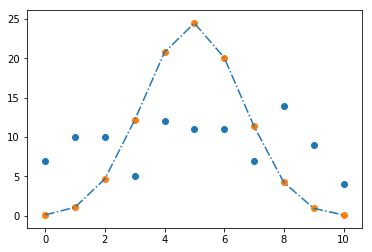

In [27]:
plt.scatter(xs, histo_ys)
plt.plot(xs, y_mean, ls='-.')
plt.scatter(xs, y_mean)
plt.show()

In [28]:
q_samples

array([ 0.48764509,  0.50909516,  0.47696613, ...,  0.47685373,
        0.51324277,  0.5182667 ])

In [29]:
y_std

array([ 0.03532727,  0.27008982,  0.87522029,  1.49818361,  1.25617855,
        0.18221131,  1.32168999,  1.46138806,  0.81366118,  0.24096639,
        0.03032573])

In [30]:
alpha_samples

array([-92.28662724, -71.85554169, -69.28112082, ...,  35.41925449,
        55.04228934,  10.37387639])

In [31]:
print(y_samples[0])
print(y_samples[100])

[  0.12465481   1.18642965   5.08144764  12.89701298  21.48127899
  24.53433729  19.45924721  10.58329585   3.77733197   0.79892423
   0.07603938]
[  0.09624131   0.96522442   4.35619783  11.65046094  20.44786353
  24.60911328  20.56749974  11.78718862   4.4331077    0.98801275
   0.09908989]


In [32]:
beta_samples

array([ 92.23719753,  71.89192634,  69.18892007, ..., -35.51190578,
       -54.98930588, -10.30077704])